In [53]:
#Загружаем библиотеки
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from numpy import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification

# Отключение некоторых лишних предупр

In [74]:
#Загружаем файл с признаками
df = pd.read_csv('machine_part.csv', )
df = df.drop(columns = ['Unnamed: 0'])
df.head()

,game_id,termination,result_coded,skill_cat,seconds,eco_cat,0,eval_std1,eval_std2,eval_std3,loss1,loss2,loss3,mean_eval,vremya1,vremya2,vremya3
0,c17b10c9-84c5-4c85-8c3b-b7866d0e25de,Time forfeit,w,2,300,A,13,22.360680,34.355980,43.091956,0.000000,0.000000,0.750000,15.538462,4.929503,6.849574,16.580611
1,63fbeb77-cbcf-4e0a-ba24-a9fcce5c5c4f,Time forfeit,w,3,600,C,67,207.761854,468.703935,345.992368,1.043478,2.409091,7.727273,73.910448,42.935285,67.584499,101.161790
2,6c678d21-9c2c-47cc-acc8-e4d4be1aeb51,Normal,b,4,600,B,34,20.529912,391.709911,807.592348,0.500000,3.272727,12.181818,27.735294,12.007573,30.279606,29.550881
3,77346e14-a662-424c-94f0-37330765c1d0,Normal,w,2,600,C,37,45.041434,24.756389,765.173356,1.153846,3.750000,8.416667,21.702703,12.552454,17.417120,24.892953
4,ad728a3a-85df-4727-a596-e0c5e56b5f8e,Normal,b,1,480,C,30,222.130717,276.295816,1057.605030,0.200000,3.000000,6.000000,39.233333,8.030497,16.321765,59.676908


In [75]:
df.dtypes

game_id          object
termination      object
result_coded     object
skill_cat         int64
seconds           int64
eco_cat          object
0                 int64
eval_std1       float64
eval_std2       float64
eval_std3       float64
loss1           float64
loss2           float64
loss3           float64
mean_eval       float64
vremya1         float64
vremya2         float64
vremya3         float64
dtype: object

In [76]:
#Переведем termination в бинарную переменную
df['termination'] = pd.Categorical(df['termination'])
df['termination'] = df['termination'].cat.codes
#Переведем result_coded в бинарную перемнную
df['result_coded'] = pd.Categorical(df['result_coded'])
df['result_coded'] = df['result_coded'].cat.codes
#Переведем eco_cat в категориальную переменную
df['eco_cat'] = pd.Categorical(df['eco_cat'])
df['eco_cat'] = df['eco_cat'].cat.codes
#Заполним возможные пропуски нулями
df = df.fillna(0)

In [77]:
df.dtypes, df.isnull().sum()

(game_id          object
 termination        int8
 result_coded       int8
 skill_cat         int64
 seconds           int64
 eco_cat            int8
 0                 int64
 eval_std1       float64
 eval_std2       float64
 eval_std3       float64
 loss1           float64
 loss2           float64
 loss3           float64
 mean_eval       float64
 vremya1         float64
 vremya2         float64
 vremya3         float64
 dtype: object,
 game_id         0
 termination     0
 result_coded    0
 skill_cat       0
 seconds         0
 eco_cat         0
 0               0
 eval_std1       0
 eval_std2       0
 eval_std3       0
 loss1           0
 loss2           0
 loss3           0
 mean_eval       0
 vremya1         0
 vremya2         0
 vremya3         0
 dtype: int64)

In [78]:
#Проверим банас классов:
df['skill_cat'].value_counts()
#Оказалось(я посмотрел в предыдущий файл), что игроки с классом 5 имеют запредельный рейтинг: 2500 и 2428. В целом их не стоит
#Убирать из датафрейма (я не знаю, как они сюда попали, т.к. классифицировал на 4 группы всего). Заменим этот класс на 4

2    5235
3    2597
1    1708
4    1626
5       1
Name: skill_cat, dtype: int64

In [80]:
df['skill_cat'] = df['skill_cat'].replace({5: 4})

In [81]:
df['skill_cat'].value_counts()

2    5235
3    2597
1    1708
4    1627
Name: skill_cat, dtype: int64

In [82]:
#Разделяем на x(признаки) и y(предсказываемые величины)
df_new = df.set_index('game_id')
df_y = df_new['skill_cat']
df_x = df_new.drop(columns = ['skill_cat'])
feature_names = df_x.columns.values

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=1337)

1. **Алгоритм Случайного Леса** (Random Forest Classifier)

In [84]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

#1)Первый параметр леса - количество деревьев 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

#2)Второй параметр - критерий, по которому считается качество разделения
criterion = ['gini', 'entropy', 'log_loss']

#3)Максимальная глубина дерева
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

#4)Минимальное количество выборок, необходимое для разделения внутреннего узла:
min_samples_split = [2, 5, 10]

#5)Минимальное количество выборок, необходимое для размещения в конечном узле. 
#Точка разделения на любой глубине будет учитываться только в том случае, 
#если она оставляет по крайней мере обучающие выборки min_samples_leaf в каждой из левой и правой ветвей
min_samples_leaf = [1, 2, 4]

#6)min_weight_fraction_leaf - не принципиально, можно оставить базовым нулем


#7)Количество функций, которые следует учитывать при поиске наилучшего разделения:
max_features = ['sqrt', 'log2']


# Method of selecting samples for training each tree
bootstrap = [True, False]

#Остальные параметря я не понял, что означают

# Создадим словарь параметров
params = {'n_estimators': n_estimators,
            'criterion' : criterion,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}

hailey_baldwin = RandomForestClassifier()
# ДЛя надежности будем использовать 100 итераций, проверять на 4 фолдах
hailey_baldwin_random = RandomizedSearchCV(estimator = hailey_baldwin, param_distributions = params, 
                                           n_iter = 100, scoring = 'roc_auc', cv = 4, verbose=5, random_state=1337, 
                                           n_jobs = -1)
hailey_baldwin_random.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


C:\Users\79160\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_s

In [85]:
hailey_baldwin_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 60,
 'criterion': 'entropy',
 'bootstrap': True}

In [86]:
#Заносим сюда нужные параметры
hailey_baldwin = RandomForestClassifier(n_estimators = 800, 
                                        min_samples_split = 5, 
                                        min_samples_leaf = 4, 
                                        max_features = 'log2',
                                        max_depth = 60,
                                        bootstrap = True,
                                        criterion = 'entropy')
hailey_baldwin.fit(X_train, y_train)
y_pred = hailey_baldwin.predict_proba(X_test)

In [87]:
# Столкнувшись с необходимостью оценки классификации >2 количеством классов, пришлось прибегать к помощи старого доборого ИИ
hailey_baldwin.classes_

array([1, 2, 3, 4], dtype=int64)

In [88]:
y_test_bin = label_binarize(y_test, classes=hailey_baldwin.classes_)

In [89]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(hailey_baldwin.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

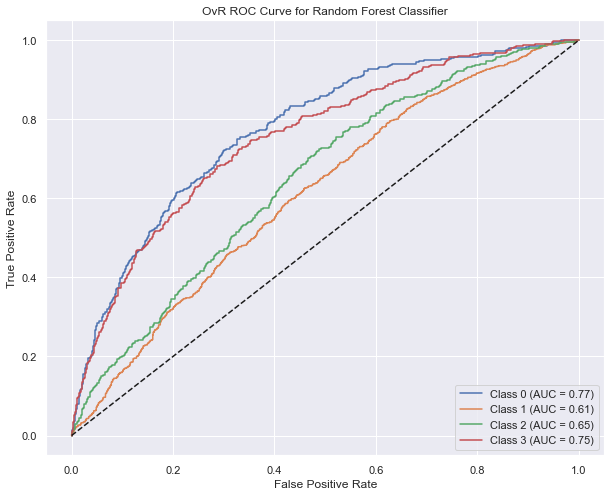

In [92]:
plt.figure(figsize=(10, 8))

for i in range(len(hailey_baldwin.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Plot the random classifier curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OvR ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()

https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

**Вывод:** В данном коде мы применили так называемый OVR метод "Один против всех". Это первый метод, который я нашел в интернете и суть его заключается в том, что каждый отдельный класс сравнивается со всеми остальными. В этом сценарии мы берем один класс и рассматриваем его как наш 1 класс, в то время как все остальные рассматриваются как 0 класс.

Также оказалось, что последний класс, который олицетворяет наиболее профессиональных игроков (рейтинг >1900) оказался слишком малым и поэтому в одном из предыдущих чанков выдалась ошибка "UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless"

2. **Алгоритм Градиентного Бустинга** (Gradient Boosing Classifier)

......